In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import os

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

# Load models
print("Loading models...")
# Democrats vs Republicans
model_republican_before_2016 = gensim.models.Word2Vec.load("models/word2vec/republican_before_2016.model")
model_republican_2017_2020 = gensim.models.Word2Vec.load("models/word2vec/republican_2017_2020.model")
model_republican_2021_2024 = gensim.models.Word2Vec.load("models/word2vec/republican_2021_2024.model")
model_conservatives_before_2016 = gensim.models.Word2Vec.load("models/word2vec/conservative_before_2016.model")
model_conservatives_2017_2020 = gensim.models.Word2Vec.load("models/word2vec/conservative_2017_2020.model")
model_conservatives_2021_2024 = gensim.models.Word2Vec.load("models/word2vec/conservative_2021_2024.model")

# Define output directory
output_dir = "output/subreddit_comparisons_v2"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016
df_before_2016 = compare_subreddit_embeddings_by_period(
    model_republican_before_2016, 
    model_conservatives_before_2016,
    "democrats", 
    "liberal",
    "before_2016",
    output_file=f"{output_dir}/republican_vs_conservatives_before_2016.csv"
)

# 2017-2020
df_2017_2020 = compare_subreddit_embeddings_by_period(
    model_republican_2017_2020, 
    model_conservatives_2017_2020,
    "democrats", 
    "liberal",
    "2017_2020",
    output_file=f"{output_dir}/republican_vs_conservatives_2017_2020.csv"
)

# 2021-2024
df_2021_2024 = compare_subreddit_embeddings_by_period(
    model_republican_2021_2024, 
    model_conservatives_2021_2024,
    "democrats", 
    "liberal",
    "2021_2024",
    output_file=f"{output_dir}/republican_vs_conservatives_2021_2024.csv"
)

print("\nAnalysis complete. Generated 3 comparison files.")

Loading models...


FileNotFoundError: [Errno 2] No such file or directory: 'models/word2vec/conservatives_before_2016.model'

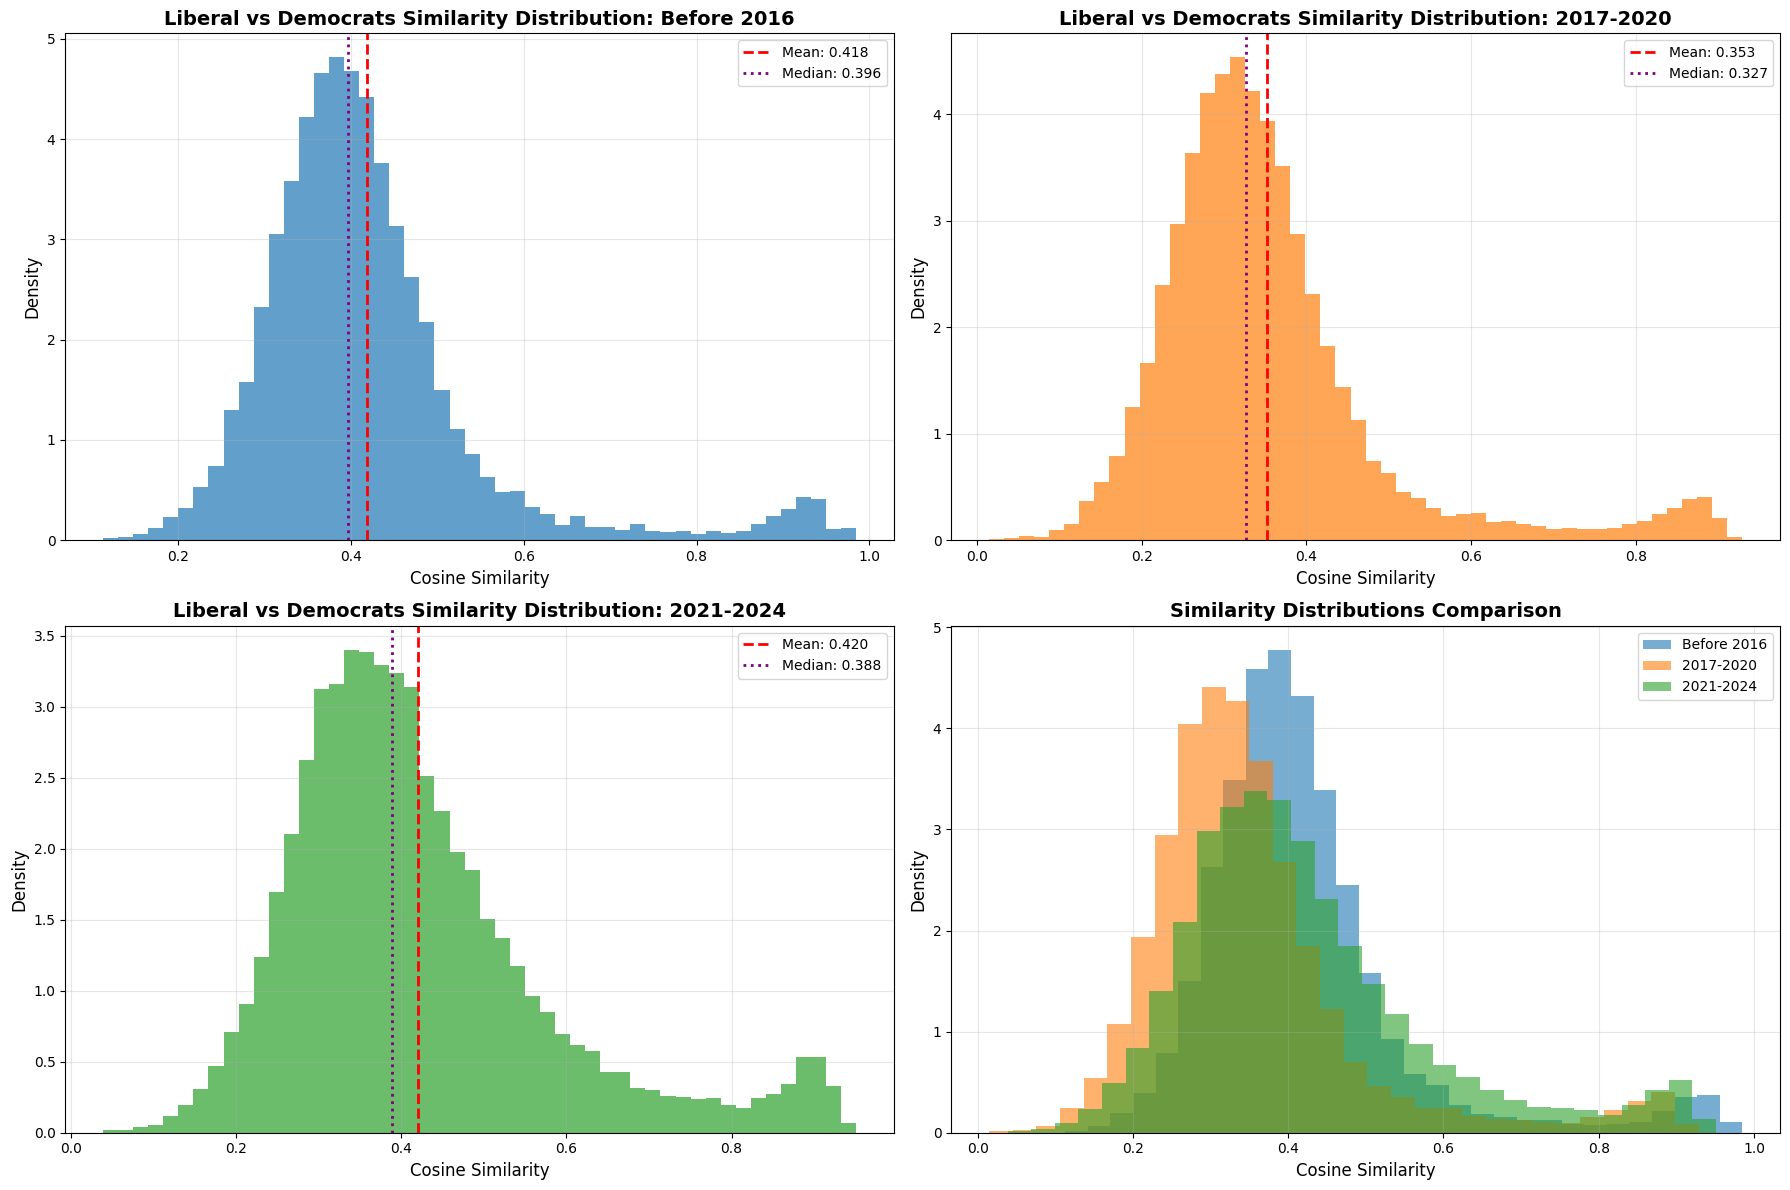


COSINE SIMILARITY DISTRIBUTION ANALYSIS

Before 2016 Statistics:
  Mean similarity: 0.4184
  Median similarity: 0.3962
  Std similarity: 0.1327
  Min similarity: 0.1129
  Max similarity: 0.9850
  Words with similarity < 0.0: 0/10956 (0.0%)
  Words with similarity < -0.1: 0/10956 (0.0%)

2017-2020 Statistics:
  Mean similarity: 0.3526
  Median similarity: 0.3267
  Std similarity: 0.1406
  Min similarity: 0.0146
  Max similarity: 0.9289
  Words with similarity < 0.0: 0/16554 (0.0%)
  Words with similarity < -0.1: 0/16554 (0.0%)

2021-2024 Statistics:
  Mean similarity: 0.4197
  Median similarity: 0.3883
  Std similarity: 0.1600
  Min similarity: 0.0387
  Max similarity: 0.9511
  Words with similarity < 0.0: 0/22523 (0.0%)
  Words with similarity < -0.1: 0/22523 (0.0%)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
df_before_2016 = pd.read_csv("output/subreddit_comparisons_v2/republican_vs_conservatives_before_2016.csv")
df_2017_2020 = pd.read_csv("output/subreddit_comparisons_v2/republican_vs_conservatives_2017_2020.csv") 
df_2021_2024 = pd.read_csv("output/subreddit_comparisons_v2/republican_vs_conservatives_2021_2024.csv")



def analyze_similarity_distributions():
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        std_sim = df['similarity'].std()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'Republican vs Conservative Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("COSINE SIMILARITY DISTRIBUTION ANALYSIS")
    
    for df, period in zip(dataframes, period_names):
        print(f"\n{period} Statistics:")
        print(f"  Mean similarity: {df['similarity'].mean():.4f}")
        print(f"  Median similarity: {df['similarity'].median():.4f}")
        print(f"  Std similarity: {df['similarity'].std():.4f}")
        print(f"  Min similarity: {df['similarity'].min():.4f}")
        print(f"  Max similarity: {df['similarity'].max():.4f}")
        print(f"  Words with similarity < 0.0: {(df['similarity'] < 0.0).sum()}/{len(df)} ({(df['similarity'] < 0.0).mean()*100:.1f}%)")
        print(f"  Words with similarity < -0.1: {(df['similarity'] < -0.1).sum()}/{len(df)} ({(df['similarity'] < -0.1).mean()*100:.1f}%)")


# Run the analysis
similarity_stats = analyze_similarity_distributions()